## Comparing the grammatical proficiency of ESL learners in the USA to that of learners in other countries

This notebook uses **[SAS](https://www.sas.com/en_us/software/university-edition.html)** to compare the grammatical proficiency of English learners in the United States to that of learners in other countries of the [Anglosphere](https://en.wikipedia.org/wiki/Anglosphere), such as the United Kingdom. The [dataset](https://osf.io/pyb8s/) came from three Boston-area professors ([Joshua Hartshorne, from Boston College](https://www.bc.edu/bc-web/schools/mcas/departments/psychology/people/faculty-directory/joshua-hartshorne.html), [Joshua Tenenbaum, from MIT](http://cocosci.mit.edu/josh), and [Steven Pinker, from Harvard](https://psychology.fas.harvard.edu/people/steven-pinker)), who collected and analyzed data from more than 600,000 people who took an [online English grammar quiz](http://web.archive.org/web/20180217125721/http://archive.gameswithwords.org/WhichEnglish/).

Reading the data:

In [83]:
/*Reading in the dataset*/
proc import datafile="English_grammar_learning/data.csv"
    out=grammar
    dbms=csv
    replace;
    getnames=yes;
    
run;

ods select Attributes; /*Only show the Attributes table*/
proc contents 
    data=grammar ; 
run;

Data Set Name,WORK.GRAMMAR,Observations,669498
Member Type,DATA,Variables,128
Engine,V9,Indexes,0
Created,07/29/2019 18:28:59,Observation Length,1208
Last Modified,07/29/2019 18:28:59,Deleted Observations,0
Protection,,Compressed,NO
Data Set Type,,Sorted,NO
Label,,,
Data Representation,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",,
Encoding,utf-8 Unicode (UTF-8),,


We see that over $660,000$ people took the [test](http://web.archive.org/web/20180217125721/http://archive.gameswithwords.org/WhichEnglish/). We want to filter the data to include people who are not native speakers and have been living in an English-speaking country for 1 or 2 years. I think if someone has been in an English-speaking country for much longer than that, she has probably achieved a near-native level of proficiency. Then we keep the data of learners in the United States and United Kingdom.

In [65]:
proc sql;
    
    create table grammar_esl as
        select currcountry, correct, Eng_country_yrs
        from work.grammar
        where (nat_Eng = 0 and Eng_country_yrs = "1") or (nat_Eng = 0 and Eng_country_yrs = "2");
        
     create table grammar_esl_us_uk as
        select currcountry, correct
        from work.grammar_esl
        where currcountry = "United States" or currcountry = "United Kingdom";
    
    
quit;

ods select Attributes;
proc contents 
    data=grammar_esl_us_uk ; 
run;



Data Set Name,WORK.GRAMMAR_ESL_US_UK,Observations,12870
Member Type,DATA,Variables,2
Engine,V9,Indexes,0
Created,07/25/2019 20:59:48,Observation Length,32
Last Modified,07/25/2019 20:59:48,Deleted Observations,0
Protection,,Compressed,NO
Data Set Type,,Sorted,NO
Label,,,
Data Representation,"SOLARIS_X86_64, LINUX_X86_64, ALPHA_TRU64, LINUX_IA64",,
Encoding,utf-8 Unicode (UTF-8),,


Plotting the counts by country of the filtered dataset:


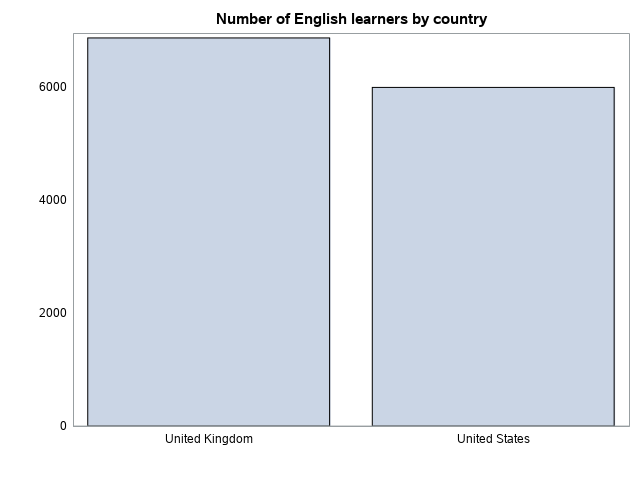

In [93]:
title 'Number of English learners by country';
proc sgplot data=grammar_esl_us_uk;
  vbar currcountry;
  yaxis label=" " DISPLAY=(NOTICKS);
  xaxis label=" " DISPLAY=(NOTICKS);
  ods graphics /  noborder;
run;

Something that stood out to me is that although the USA has several times the population of the UK, more people from Great Britain signed up to take the test.

Computing the confidence intervals and running the hypothesis tests.


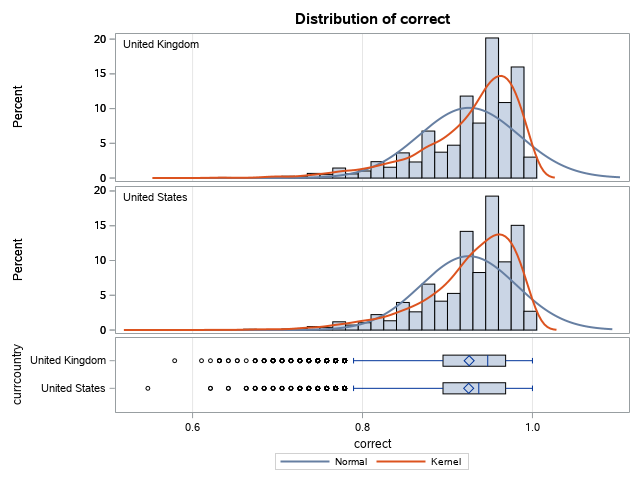

In [123]:
title 'Confidence intervals and hypothesis test';
/* 95% confidence intervals
 * Hypothesis test:
 * Ho: There is no statistically significant difference between the correct scores of the two groups
 * Ha: There is a statistically significant difference between the correct scores of the two groups
 */
proc ttest data=grammar_esl_us_uk sides=2 h0=0 plots(only)=(summaryPlot );
    class currcountry;
    var correct;
run;

We see in the second table that the $95\%$ confidence interval of the difference is $(-0.00149,\  0.00252)$. Since the interval crosses $0$, we know that the difference in average scores between the two groups (USA and UK) will not be significant. The third table, the t-test, corroborates: if there is no difference in average scores between the 2 groups, i.e., if the null hypothesis is true, then the probability of seeing data as extreme or more as the one we have is 61.4%, which is very high, so **we cannot reject the null hypothesis that there is no significant difference in scoring between the two groups**. 

We can verify the confidence interval calculation using the numbers from the first table. The confidence interval of the difference in average scores between the two groups is:

$$
95\%\ CI = (\bar{x}_{UK}-\bar{x}_{USA}) \pm 1.96\cdot SE_{(\bar{x}_{UK} - \bar{x}_{USA})} = (\bar{x}_{UK}-\bar{x}_{USA}) \pm 1.96\cdot \sqrt{\frac{s^2_{UK}}{n_{UK}} + \frac{s^2_{USA}}{n_{USA}}}
$$

where $\bar{x}_{UK}$ and $\bar{x}_{USA}$ are the means of the two groups, UK and USA; $SE_{(\bar{x}_{UK} - \bar{x}_{USA})}$ is the pooled standard error, which can be computed using $s_{UK}$, $n_{UK}$, $s_{USA}$, and $n_{USA}$, which are the standard deviations and sizes of the two samples.

Looking at the first table above, we have $\bar{x}_{UK}=0.9255$ and $\bar{x}_{USA}=0.9250$; $s_{UK}=0.0592$, $n_{UK}=6873$, $s_{USA}=0.0563$, and $n_{USA}=5997$, which gives a pooled standard error of $SE_{(\bar{x}_{UK} - \bar{x}_{USA})}=1.01905E-3$, and so the confidence interval is:

$$
95\% \  CI = (0.9255-0.9250)\pm 1.96\cdot 1.01905E-3 = 5E-4 \pm 1.99734E-3 = (-1.4973E-3,\ 2.49734E-3)
$$

which is basicaly the same computed in the second table above (pooled method).


I found these results to mostly hold when comparing with other English-speaking countries like Canada, New Zealand, and Australia. That is to say, in some cases there *was* a statistically significant difference but not a ***practically*** significant one. For example, here is the comparison to Canada:

In [122]:
proc sql;
        
     create table grammar_esl_us_canada as
        select currcountry, correct
        from work.grammar_esl
        where currcountry = "United States" or currcountry = "Canada";
    
    
quit;

ods select ConfLimits Statistics Ttests;
proc ttest data=grammar_esl_us_canada sides=2 h0=0 ;
    class currcountry;
    var correct;
run;

We can see in the second table that we would be $95\%$ confident that the true difference in scores between Canadian and American learners is between $0.83\%$ and $1.23\%$, favoring the USA, but it would be hard to argue that it is a pragmatic one. Comparisons with other countries yielded similar results.